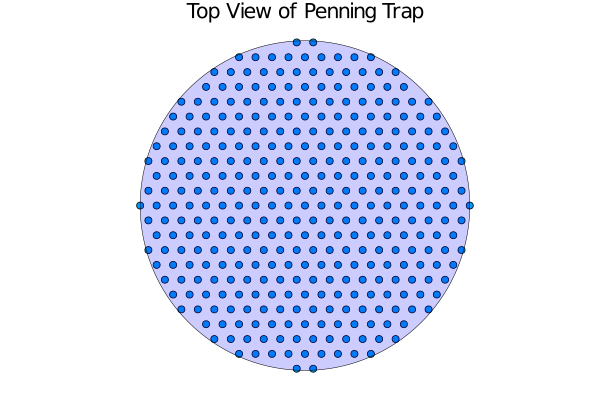

In [1]:
interionic_spacing = .1
up_modifier = sqrt(3)/2 * interionic_spacing
over_modifer = 1/2 * interionic_spacing
points_inside_circle = []
digits = 2
function gen_points(pt, points_inside_circle, x, y)
    pt = [round(pt[1], digits=digits), round(pt[2], digits=digits)]
    if pt in points_inside_circle || pt[1]^2 + pt[2]^2 > 1
        return
    else
        push!(points_inside_circle, pt)
        push!(x, pt[1])
        push!(y, pt[2])
        gen_points([pt[1] + over_modifer, pt[2] - up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] - over_modifer, pt[2] - up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] - over_modifer, pt[2] + up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] + over_modifer, pt[2] + up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] + interionic_spacing, pt[2]], points_inside_circle, x, y)
        gen_points([pt[1] + interionic_spacing, pt[2]], points_inside_circle, x, y)
        gen_points([pt[1] - interionic_spacing, pt[2]], points_inside_circle, x, y)
        return points_inside_circle, x, y
    end
end
pairs, x, y = gen_points([0, 0], [], [], [])
function circleShape(h, k, r)
    θ = LinRange(0, 2*π, 500)
    h .+ r*sin.(θ), k .+ r*cos.(θ)
end
using Plots
gr() # We will continue onward using the GR backend
plot(x, y, seriestype = :scatter, title = "Top View of Penning Trap")
plot!(circleShape(0, 0, 1), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=.2, aspect_ratio = 1, axis=nothing, border=:none)

In [2]:
function plot_triangles_across_unit_disk(f, x, y)
    ret = []
    for (i, xx) in enumerate(x)
        print(i)
        ρ = sqrt(xx^2 + y[i]^2)
        ϕ = atan(y[i], xx)
        res = f(ρ, ϕ)
        push!(ret, res)
        end
    ret
end

plot_triangles_across_unit_disk (generic function with 1 method)

In [3]:
using SpecialFunctions
using QuantumOptics

function fidelity(ρ, σ)
    tr(sqrt(sqrt(ρ) * σ * sqrt(ρ)))^(1/2)
end

function R(n::Int64, m::Int64, ρ::Float64)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            n = big(n)
            k = big(k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end

function unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t)
    Pevens = []
    eventuples = []
    for (m, zeven) in enumerate(zernike_coefficients_even)
        meven = m - 1
        push!(Pevens, [zeven[i] * R(i-1, meven, ρ) for i in Array(range(1, length(zeven), step=1))])
    end
    for i in range(1, length(Pevens), step=1)
        rotationeven = - (i - 1) * ω * t
        total = sum(Pevens[i])
        push!(eventuples, (i - 1, total, rotationeven))
    end
    eventuples # No odd tuples, so we'll leave it simple. (In fact, only m=0 again but we'll test this.)
end

toarray(s::Union{Set, Array}) = [toarray.(s)...]
toarray(v::Number) = v

toarray (generic function with 2 methods)

In [4]:
r2 = .6
r1 = .4
function Q(n::Int64, r2::Float64, r1::Float64)
    if n % 2 != 0
        0
    else
        function summand(k)
            n = big(n)
            k = big(k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(big(Int(n/2 - k)))*factorial(big(Int(n/2 - k))))*((r2)^(n-2*k + 1)-(r1)^(n-2*k + 1))/(n-2k+1)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n)/2), step=1)))
    end

        end

function R(n::Int64, m::Int64, ρ::Float64)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            n = big(n)
            k = big(k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end


R (generic function with 1 method)

In [6]:
Γ = 1/62
ω = 2*π*180E3
θ = 0.;
σ = .1
b = SpinBasis(1//2)
ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
max_n = 10
scale = 1
zernikeeven = [[Q(i, r2, r1) for i in range(0, 10, step=1)]]
zernikeodd = []
evolution_time = 50E-6
U = π/(evolution_time) * 2
step_size = evolution_time/1
T = [0.0:step_size:evolution_time;];

μ = 0
order =  0

function evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, ψ, μ, ω, b)
    function evaluator(ρ, ϕ)
        H(t, _) = H_odf(ρ, ϕ, t, zernikeeven, zernikeodd, U, ψ, μ, ω)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
        _, ψTARGET = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])
        last(ψTARGET)
    end
end
function H_odf(ρ, ϕ, t, zernike_coefficients_even, zernike_coefficients_odd, U, ψ, μ, ω)
    U * cos(sum([Q(i, r2, r1)*R(i,0,ρ) for i in range(0, max_n, step=1)])) 
end
exact_evolution_evaluator = evolution_evaluator_factory(ψ0, T, zernikeeven, [], U, θ, 0., ω, b)


function infidelity_across_disk(F1, F2)
    function infidelity_polar(ρ, ϕ)
        ψ1 = F1(ρ, ϕ).data
        ψ2 = F2(ρ, ϕ).data
        1 - real(fidelity(ψ1, ψ2))
    end
end

function annulus(a, b)
    function rtn(ρ, ϕ)
        if a < ρ < b
            1
        else
            0
        end
    end
end

function annulus_spin_profile(ρ, ϕ)
    ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
    H(t, _) = U * cos(annulus(r1, r2)(ρ, ϕ)) * sigmaz(b), [], []
    _, ψ = timeevolution.master_dynamic(T, ψ0, H)
    last(ψ)
end

annulus_spin_profile (generic function with 1 method)

In [7]:
z = plot_triangles_across_unit_disk(infidelity_across_disk(annulus_spin_profile, exact_evolution_evaluator), x, y)

123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100101102103104105106107108109110111112113114115116117118119120121122123124125126127128129130131132133134135136137138139140141142143144145146147148149150151152153154155156157158159160161162163164165166167168169170171172173174175176177178179180181182183184185186187188189190191192193194195196197198199200201202203204205206207208209210211212213214215216217218219220221222223224225226227228229230231232233234235236237238239240241242243244245246247248249250251252253254255256257258259260261262263264265266267268269270271272273274275276277278279280281282283284285286287288289290291292293294295296297298299300301302303304305306307308309310311312313314315316317318319320321322323324325326327328329330331332333334335336337338339340341342343344345346347348349350351

351-element Array{Any,1}:
 0.001656715771727324
 0.002376208719363837
 0.005377502622067154
 0.012102934918676644
 0.07216789866121409
 0.07149980639194908
 0.010101215193846103
 0.002824328588900915
 0.0008552366161250768
 0.0008200024025374342
 0.00041211420194020576
 0.0007643478522209035
 0.0007709225043968093
 ⋮
 0.00020444968738120295
 0.0003737904179400564
 0.0006088333470666285
 0.0006829225711934006
 0.000651428643092089
 0.00048551866557611234
 0.0007994863856499723
 0.0008093589322144545
 0.000490902649905256
 0.0008190976893140967
 0.0007709225043968093
 0.00041211420194020576

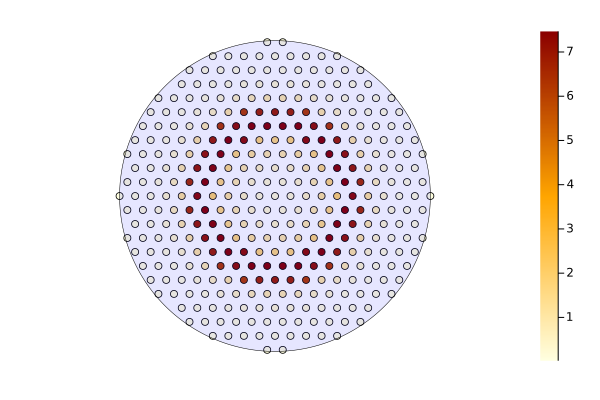

In [8]:
using Plots
#plot(x, y, seriestype = :scatter, title = "Top View of Penning Trap")
scatter(x, y, marker_z = 100*z,  c = :heat)
plot!(circleShape(0, 0, 1), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=.1, aspect_ratio = 1, axis=nothing, border=:none)


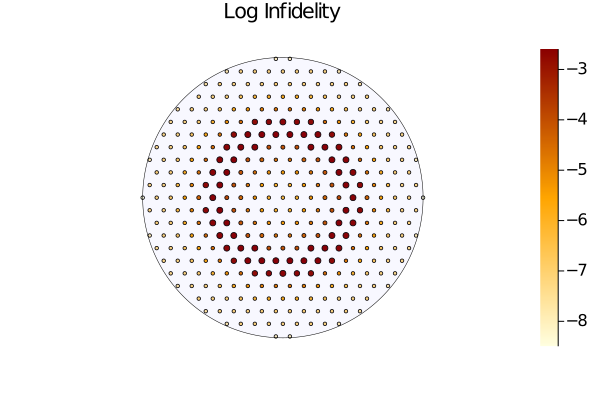

In [81]:
using Plots
#plot(x, y, seriestype = :scatter, title = "Top View of Penning Trap")
scatter(x, y, marker_z = log.(z), markersize=20*z.+2,  c = :heat, xlabel="x", ylabel="y")
plot!(circleShape(0, 0, 1), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=.03, aspect_ratio = 1, axis=nothing, border=:none, title="Log Infidelity")


# n = 10

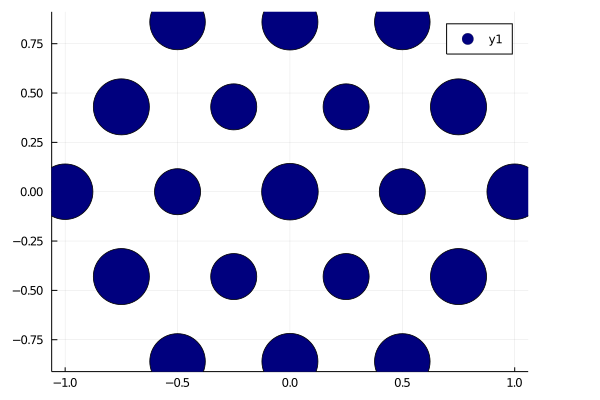

GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range


In [14]:
using Plots
scatter(x, y, marker_z = z, markersize = 50*z,  color = :jet)

# n = 5

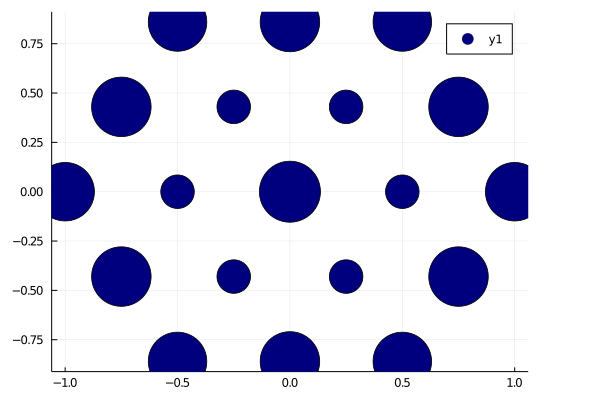

GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range


In [78]:
using Plots
scatter(x, y, marker_z = z, markersize = 50*z,  color = :jet)